In [2]:
import sys
sys.path.insert(0,r'(path)...\chemical_vae-main')

## Load libraries

In [ ]:
# tensorflow backend
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu
# import scientific py
import numpy as np
import pandas as pd
# rdkit stuff
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Load a model

In [ ]:
vae = VAEUtils(directory=r'(path)...chemical_vae-main\models\zinc_properties')

# Using the VAE


## Decode/Encode 

Might not be perfect (it's probabilistic), try it several times.

smiles <i class="fa fa-arrow-right" aria-hidden="true"></i> x <i class="fa fa-arrow-right" aria-hidden="true"></i> z <i class="fa fa-arrow-right" aria-hidden="true"></i> x_r <i class="fa fa-arrow-right" aria-hidden="true"></i> smiles_r

In [29]:
smiles_1 = mu.canon_smiles('CC(=O)OC1=CC=CC=C1C(=O)O') #run your smiles instead of CC(=O)OC1=CC=CC=C1C(=O)O (aspirin)

X_1 = vae.smiles_to_hot(smiles_1,canonize_smiles=True)
z_1 = vae.encode(X_1)
X_r= vae.decode(z_1)

print('{:20s} : {}'.format('Input',smiles_1))
print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r,strip=True)[0]))

print('{:20s} : {} with norm {:.3f}'.format('Z representation',z_1.shape, np.linalg.norm(z_1)))

Input                : CC(=O)Oc1ccccc1C(=O)O
Reconstruction       : C(=O)NOc1ccccc1C(N)=O
Z representation     : (1, 196) with norm 11.748


## property preditor

In [30]:
print('Properties (qed,SAS,logP):')
y_1 = vae.predict_prop_Z(z_1)[0]
print(y_1)

Properties (qed,SAS,logP):
[0.7243109 2.2545815 0.5201503]


## Decode several attempts
VAE are probabilistic

Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Found 4 unique mols, out of 90
SMILES
 0    CC(=O)Oc1ccccc1C(=O)O
1    CC(=O)Oc1ccccc1C(N)=O
2    C(C=O)Oc1ccccc1C(N)=O
3    C(OCO)Oc1ccccc1C(N)=O
Name: smiles, dtype: object


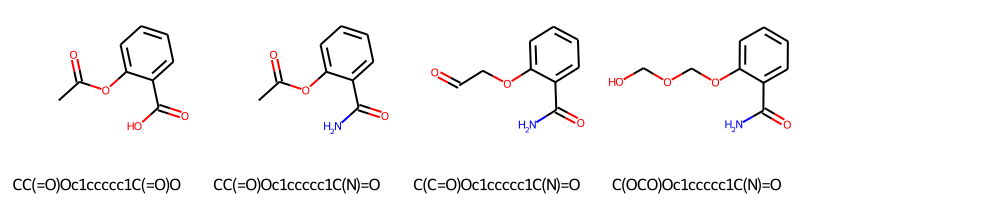

,smiles,distance,count,frequency,mol
0,CC(=O)Oc1ccccc1C(=O)O,0.000005,8,0.088889,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,CC(=O)Oc1ccccc1C(N)=O,2.798941,77,0.855556,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,C(C=O)Oc1ccccc1C(N)=O,8.330380,1,0.011111,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,C(OCO)Oc1ccccc1C(N)=O,8.847330,4,0.044444,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [31]:
noise=5.0
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles( z_1,decode_attempts=100,noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
df.head()

## PCA of latent space

Sample random points from the training set along with properties

In [33]:
Z, data, smiles = vae.ls_sampler_w_prop(size=50000,return_smiles=True)
prop_opt = 'qed'
prop_df = pd.DataFrame(data).reset_index()
prop_df['smiles']=smiles
prop_df.head()

,index,logP,qed,SAS,smiles
0,101358,4.71628,0.274199,2.614613,C=CCN1C(=O)C(C#N)=C(C)/C(=C\c2cn(-c3ccccc3)nc2...
1,15988,1.95552,0.833801,2.371268,Cc1cc(NC(=O)c2ccc(Br)cc2N)ccc1C(=O)[O-]
2,91429,-0.79388,0.680975,4.718080,Cc1nnc(CCC[NH+](C)C[C@H](C)O)o1
3,236490,4.50180,0.712837,2.463301,CC(C)CCCNC(=O)N[C@H](C)c1cccc(C(F)(F)F)c1
4,84136,3.65320,0.888548,1.987124,O=S(=O)(c1ccc(Nc2ccccc2Cl)nc1)N1CCCCC1


Perform a PCA projection and color the points based on a property

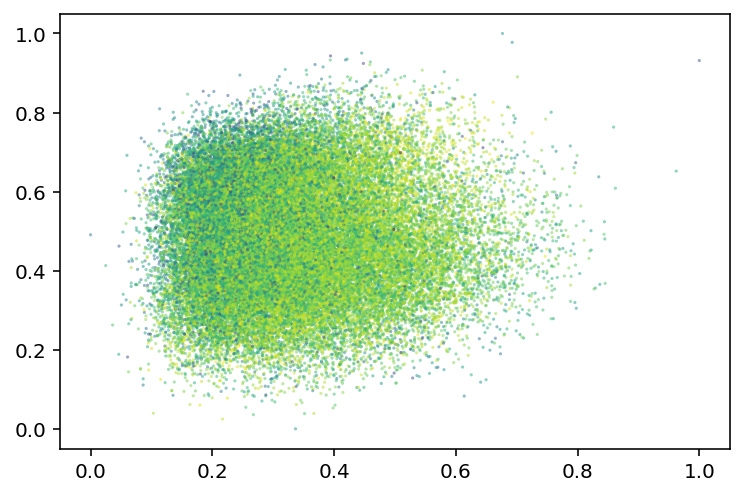

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# do pca and normalize
Z_pca = PCA(n_components=2).fit_transform(Z)
Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()

compare with t-SNE, will take some time

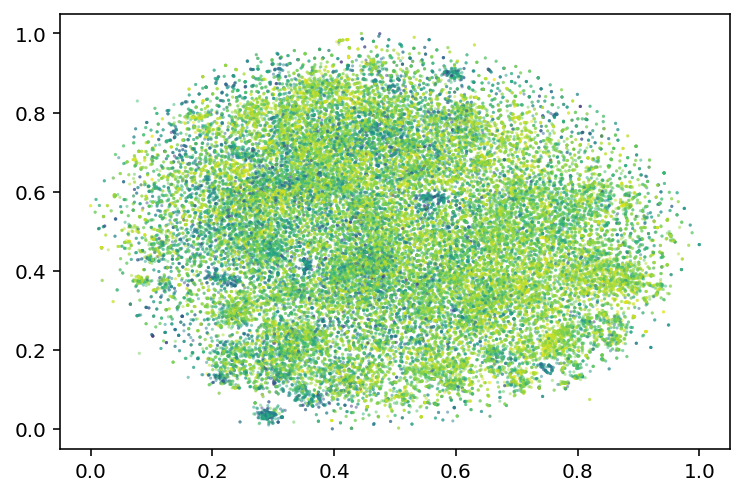

In [34]:
from sklearn.manifold import TSNE

Z_tsne = TSNE(n_components=2).fit_transform(Z)
Z_tsne = MinMaxScaler().fit_transform(Z_tsne)

df = pd.DataFrame(np.transpose((Z_tsne[:,0],Z_tsne[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()
# df.columns = ['x','y']
# df[prop_opt]=prop_df[prop_opt]

# plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
#             cmap= 'viridis', marker='.',
#             s=10,alpha=0.5, edgecolors='none')
# plt.show()